In [1]:
import pandas as pd
import numpy as np
from dsipts import TimeSeries, RNN,read_public_dataset, LinearTS, Persistent, TFT
import matplotlib.pyplot as plt
from datetime import timedelta
import logging
import sys
import random


In [2]:
def random_walk(n,level=30):
    tot = np.zeros(n)
    probs = np.zeros(n)
    for i in range(n-1):
        prob = random.random()
        if prob<0.5:
            delta = 1
        else:
            delta = -1
        tot[i+1] = tot[i] + delta
        probs[i+1]= prob +(random.random()/level-0.5/level)
    return tot, probs
N = 20000
random.seed(18)
x, p = random_walk(N)
data = pd.DataFrame({'y':x/x.max(),'p':p,'time':range(N)})

In [26]:
from catboost import CatBoostRegressor
regressor = CatBoostRegressor(loss_function='MultiRMSE',iterations=2000)


In [4]:
##load the timeseries to the datastructure, adding the hour column and use all the covariates
ts = TimeSeries('weather')
ts.load_signal(data,enrich_cat=[],target_variables=['y'],past_variables= [],future_variables=['p'])
ts

Timeseries named weather of length 20000.
 Categorical variable: [],
 Future variables: ['p'],
 Past variables: ['y'],
 Target variables: ['y']
 With no group

In [5]:
#Let now prepare a model predictin the next 16 step using the past 16 steps 
past_steps = 1
future_steps = 64


In [16]:
##splitting parameters
split_params = {'perc_train':0.6,'perc_valid':0.2,                             ##if not None it will split 70% 10% 20%
               'range_train':None, 'range_validation':None, 'range_test':None, ## or we can split using ranges for example range_train=['2021-02-03','2022-04-08']
               'past_steps':past_steps,
               'future_steps':future_steps,
               'shift':0,
               'starting_point':None,                                          ## do not skip samples
               'skip_step' : 1                                                 ## distance between two consecutive samples
                             }

In [17]:
train,validation,test = ts.split_for_train(**split_params)

In [20]:
def transform(dataset):
    x_num = dataset.data['x_num_past']
    x_fut =  dataset.data['x_num_future']
    y =  dataset.data['y'].squeeze()
    x = np.hstack([x_num.squeeze(2),x_fut.squeeze(2)])
    return x,y

In [21]:
x,y = transform(train)
eval_set= transform(validation)

In [27]:
regressor.fit(x,y,eval_set=eval_set)

0:	learn: 7.7930023	test: 16.2532066	best: 16.2532066 (0)	total: 565ms	remaining: 18m 49s
1:	learn: 7.5992068	test: 16.0156076	best: 16.0156076 (1)	total: 1.18s	remaining: 19m 33s
2:	learn: 7.4092003	test: 15.8388206	best: 15.8388206 (2)	total: 1.79s	remaining: 19m 51s
3:	learn: 7.2142472	test: 15.5587172	best: 15.5587172 (3)	total: 2.4s	remaining: 19m 56s
4:	learn: 7.0356879	test: 15.3298906	best: 15.3298906 (4)	total: 2.98s	remaining: 19m 48s
5:	learn: 6.8511594	test: 15.0752561	best: 15.0752561 (5)	total: 3.61s	remaining: 19m 59s
6:	learn: 6.6701637	test: 14.7989133	best: 14.7989133 (6)	total: 4.24s	remaining: 20m 6s
7:	learn: 6.5013079	test: 14.5794169	best: 14.5794169 (7)	total: 4.91s	remaining: 20m 23s
8:	learn: 6.3323180	test: 14.3373737	best: 14.3373737 (8)	total: 5.53s	remaining: 20m 24s
9:	learn: 6.1779188	test: 14.0905469	best: 14.0905469 (9)	total: 6.1s	remaining: 20m 14s
10:	learn: 6.0261009	test: 13.8446865	best: 13.8446865 (10)	total: 6.73s	remaining: 20m 17s
11:	learn: 

In [23]:
transform(test)
res =regressor.predict(transform(test)[0])

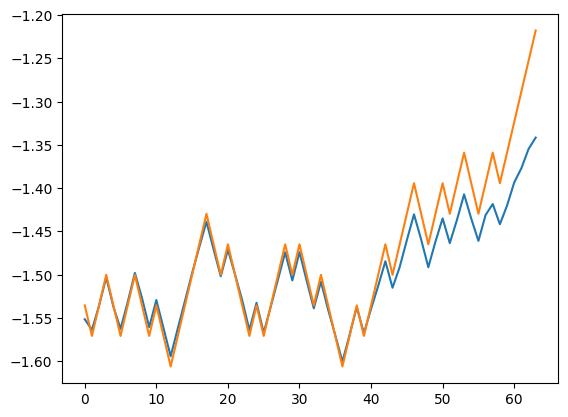

In [25]:
plt.plot(res[18])
plt.plot(transform(test)[1][18])

In [146]:
%matplotlib qt
lag = 15

plt.plot(res[res.lag==lag].time, res[res.lag==lag].y,label='real',alpha=0.5)
plt.plot(res[res.lag==lag].time, res[res.lag==lag].y_pred,label='pred',alpha=0.5)

plt.title('Prediction on test for lag=7')
plt.legend()

In [147]:
res['prediction_time'] = res.apply(lambda x: int(x.time-x.lag), axis=1)

In [148]:
res

,lag,time,y,y_pred,prediction_time
0,1,16064,0.377953,0.399360,16063
1,1,16065,0.370079,0.389656,16064
2,1,16066,0.377953,0.395594,16065
3,1,16067,0.385827,0.403635,16066
4,1,16068,0.377953,0.401778,16067
...,...,...,...,...,...
247803,64,19994,0.771654,0.673848,19930
247804,64,19995,0.763780,0.676096,19931
247805,64,19996,0.755906,0.673301,19932
247806,64,19997,0.748031,0.675759,19933


In [150]:
%matplotlib qt
date = 19932

plt.plot(res[res.prediction_time==date].time, res[res.prediction_time==date].y,label='real',alpha=0.5)
plt.plot(res[res.prediction_time==date].time, res[res.prediction_time==date].y_pred,label='pred',alpha=0.5)
#plt.ylim(res.y.min(),res.y.max())
plt.title('Prediction on test for lag=7')
plt.legend()

In [ ]:
## get the median MSE for each lag
import numpy as np
res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 

In [ ]:
#save model 
ts.save(f"{model_to_use}_test")

In [ ]:
## load the model and check if we obtain the same result

In [ ]:
ts.load(LinearTS,f"{model_to_use}_test",load_last=False)
res = ts.inference_on_set(200,4,set='test',rescaling=True)
error = res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 
error

In [ ]:
##print the mean MSE along the lag steps
plt.plot(error.lag,error.error)

In [ ]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = res
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = res[res.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_median,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()

In [ ]:
tot = pd.read_csv('/home/agobbi/Projects/ExpTS/csv/prova_test_tot_predictions.csv')
tot.time = pd.to_datetime(tot.time)

In [ ]:
pers = tot[(tot.model=='persistent_weather_1')]

In [ ]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = pers
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = pers[pers.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_pred,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()